In [8]:
from google.colab import drive
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten, Dense, Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from PIL import Image, ImageFile, UnidentifiedImageError
import scipy
import logging

ImageFile.LOAD_TRUNCATED_IMAGES = True

In [9]:
drive.mount('/content/drive')
base_folder_path = '/content/drive/My Drive/dataset/Penyakit Kulit'
train_folder_path = os.path.join(base_folder_path, 'Train')
val_folder_path = os.path.join(base_folder_path, 'Validation')
test_folder_path = os.path.join(base_folder_path, 'Test')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
def read_image_files_in_folder(folder_path):
    files = os.listdir(folder_path)
    images = []
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(folder_path, file)
            image = Image.open(file_path)
            images.append(image)
            print(f'Reading image: {file}')
            plt.imshow(image)
            plt.show()
    return images

train_images = read_image_files_in_folder(train_folder_path)
val_images = read_image_files_in_folder(val_folder_path)
test_images = read_image_files_in_folder(test_folder_path)

In [11]:
def count_folders_in_directory(directory_path):
    items = os.listdir(directory_path)
    folders = [item for item in items if os.path.isdir(os.path.join(directory_path, item))]
    return len(folders), folders

# Hitung jumlah folder dalam folder train
train_folder_count, train_folders = count_folders_in_directory(train_folder_path)
print(f'Number of folders in train: {train_folder_count}')
print('Folders:', train_folders)

# Hitung jumlah folder dalam folder validation
val_folder_count, val_folders = count_folders_in_directory(val_folder_path)
print(f'Number of folders in val: {val_folder_count}')
print('Folders:', val_folders)

# Hitung jumlah folder dalam folder test
test_folder_count, test_folders = count_folders_in_directory(test_folder_path)
print(f'Number of folders in test: {test_folder_count}')
print('Folders:', test_folders)


Number of folders in train: 16
Folders: ['Herpes HPV and other STDs', 'Vasculitis Photos', 'Warts Molluscum and other Viral Infections', 'Melanoma Skin Cancer Nevi and Moles', 'Scabies Lyme Disease and other Infestations and Bites', 'Vascular Tumors', 'Healthy', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Lupus and other Connective Tissue Diseases', 'Bullous Disease', 'Acne and Rosacea', 'Nail Fungus and other Nail Disease', 'Eczema', 'Exanthems and Drug Eruptions', 'Seborrheic Keratoses and other Benign Tumors', 'Urticaria Hives']
Number of folders in val: 16
Folders: ['Melanoma Skin Cancer Nevi and Moles', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Vasculitis Photos', 'Acne and Rosacea', 'Scabies Lyme Disease and other Infestations and Bites', 'Warts Molluscum and other Viral Infections', 'Lupus and other Connective Tissue Diseases', 'Bullous Disease', 'Herpes HPV and other STDs', 'Nail Fungus and other Nail Disease', 'Seborrheic Keratoses and other Ben

In [12]:
# Custom Data Generator to handle corrupted images
class SafeImageDataGenerator(ImageDataGenerator):
    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=self.dtype)
        batch_y = np.zeros((len(index_array), self.num_classes), dtype=self.dtype)
        valid_samples = 0

        for i, j in enumerate(index_array):
            fname = self.filepaths[j]
            try:
                img = self.load_img(fname, color_mode=self.color_mode,
                                    target_size=self.target_size,
                                    interpolation=self.interpolation)
                x = self.img_to_array(img)
                x = self.standardize(x)
                batch_x[valid_samples] = x
                batch_y[valid_samples, self.classes[j]] = 1.
                valid_samples += 1
            except (OSError, ValueError, Image.UnidentifiedImageError) as e:
                logger.warning(f"Skipping corrupted image: {fname}, Error: {e}")

        return batch_x[:valid_samples], batch_y[:valid_samples]

In [13]:
train_datagen = SafeImageDataGenerator(rescale=1.0/255.0,)
val_datagen = SafeImageDataGenerator(rescale=1.0/255.0)
test_datagen = SafeImageDataGenerator(rescale=1.0/255.0)

# Create the generators
train_generator = train_datagen.flow_from_directory(
    train_folder_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_folder_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_folder_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 3353 images belonging to 16 classes.
Found 883 images belonging to 16 classes.
Found 748 images belonging to 16 classes.


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Load the pre-trained InceptionV3 model
pre_trained_model = InceptionV3(input_shape=(300, 300, 3),
                                include_top=False,
                                weights='imagenet')

# Freeze the layers of the pre-trained model
for layer in pre_trained_model.layers:
    layer.trainable = False

# Function to create the final model
def create_final_model(pre_trained_model):
    output = pre_trained_model.output
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(output)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    predictions = Dense(16, activation='softmax')(x)

    model = Model(inputs=pre_trained_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the final model
model = create_final_model(pre_trained_model)

# Define callbacks
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=10,
                    verbose=1,
                    callbacks=[checkpoint, early_stopping])

Epoch 1/10
105/105 [==============================] - 94s 842ms/step - loss: 2.3351 - accuracy: 0.2962 - val_loss: 1.1590 - val_accuracy: 0.6818
Epoch 2/10
105/105 [==============================] - 74s 704ms/step - loss: 1.5755 - accuracy: 0.5136 - val_loss: 0.7569 - val_accuracy: 0.8075
Epoch 3/10
105/105 [==============================] - 73s 697ms/step - loss: 1.1399 - accuracy: 0.6669 - val_loss: 0.5206 - val_accuracy: 0.8573
Epoch 4/10
105/105 [==============================] - 71s 676ms/step - loss: 0.8141 - accuracy: 0.7745 - val_loss: 0.3715 - val_accuracy: 0.9185
Epoch 5/10
105/105 [==============================] - 87s 835ms/step - loss: 0.5512 - accuracy: 0.8619 - val_loss: 0.2329 - val_accuracy: 0.9626
Epoch 6/10
105/105 [==============================] - 84s 796ms/step - loss: 0.3571 - accuracy: 0.9380 - val_loss: 0.1779 - val_accuracy: 0.9785
Epoch 7/10
105/105 [==============================] - 87s 833ms/step - loss: 0.2302 - accuracy: 0.9735 - val_loss: 0.1158 - val_ac

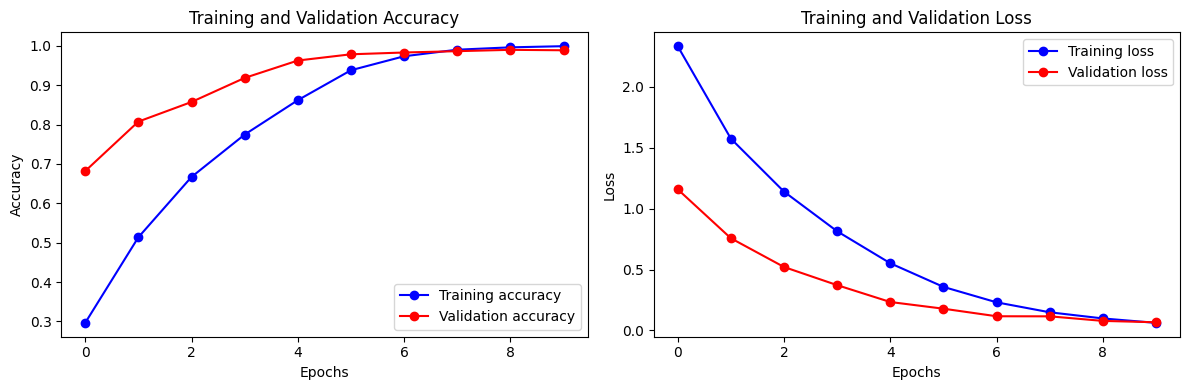

In [17]:
import matplotlib.pyplot as plt

# Extracting the accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Number of epochs
epochs = range(len(acc))

# Plotting training and validation accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
loss, accuracy = model.evaluate(test_generator)
print(f'Test Loss : {loss}')
print(f'Test Accuracy: {accuracy}')

24/24 [==============================] - 410s 18s/step - loss: 0.2847 - accuracy: 0.9425
Test Loss : 0.2847212851047516
Test Accuracy: 0.9425133466720581


In [16]:
model.save('InceptionV3_model(128_64).h5')